In [1]:
# data stuff:
import pandas as pd
import numpy as np

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# modeling stuff:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# silence!
import warnings
# warnings.filterwarnings("ignore")

---
## 📊 Customer Segmentation:
Below we cover:

* K-means Clustering






**📄 Dataset:** UCI Online Retail Data Set (https://archive.ics.uci.edu/ml/datasets/online+retail)

📚 See chapter 19 of _"Data Science for Marketing"_ by Hwang, page 342.

---

### Import and Clean Data:

In [2]:
data = pd.read_csv('data/Online Retail.csv')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


&nbsp;
#### Define data cleaning and transforming function:
Following the "pandas best practices" as outlined by Matt Harrison in "Effective Pandas", chapter 21, page 225.

In [3]:
def tweak_retail_data(df):
    tweaked_df = (df
                  .query('Quantity > 0')
                  .assign(InvoiceDate=lambda df_: pd.to_datetime(df_['InvoiceDate']))
                  .query('InvoiceDate < "2011-12-01"')
                  .dropna(subset=['CustomerID'])
                  .assign(Sales=lambda df_: df_['Quantity']*df_['UnitPrice'])
                  .groupby('CustomerID').agg({'Sales': sum, 'InvoiceNo': lambda x: x.nunique()})
                  .rename(columns={'InvoiceNo': 'OrderCount'})
                  .assign(AvgOrderValue = lambda df_: np.round(df_['Sales']/df_['OrderCount'], 2))
                 )
    return tweaked_df

In [4]:
# return cleaned and transformed df:
customer_df = tweak_retail_data(data)
customer_df

,Sales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.60
12347.0,4085.18,6,680.86
12348.0,1797.24,4,449.31
12349.0,1757.55,1,1757.55
12350.0,334.40,1,334.40
...,...,...,...
18280.0,180.60,1,180.60
18281.0,80.82,1,80.82
18282.0,100.21,1,100.21


&nbsp;
#### Normalize the customer data:
Clustering algorithms are sensitive to differences in scale, so we'll normalize everything on the same scale.

In [5]:
# define a rank dataframe:
rank_df = customer_df.rank(method='first')
rank_df

,Sales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
...,...,...,...
18280.0,571.0,1537.0,1094.0
18281.0,104.0,1538.0,169.0
18282.0,158.0,1539.0,266.0


In [6]:
# then, normalize the df:
normalized_df = (rank_df - rank_df.mean())/rank_df.std()
normalized_df

,Sales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
...,...,...,...
18280.0,-1.272091,-0.493605,-0.850613
18281.0,-1.648440,-0.492799,-1.596058
18282.0,-1.604922,-0.491993,-1.517887


&nbsp;

---
### K-Means Clustering
We'll perform customer segmentation with k-means.

&nbsp;
#### Define K-means model and instantiate (k=4):

In [7]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['Sales', 'OrderCount', 'AvgOrderValue']])
kmeans

KMeans(n_clusters=4)

&nbsp;
#### Define a cluster dataframe and obtain each customers assigned cluster:

In [8]:
four_cluster_df = normalized_df[['Sales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head(5)

,Sales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,3
12347.0,1.457445,1.064173,1.401033,0
12348.0,0.967466,0.573388,0.929590,0
12349.0,0.944096,-1.730641,1.683093,3
12350.0,-0.732148,-1.729835,0.331622,3


&nbsp;
#### Plot clusters:

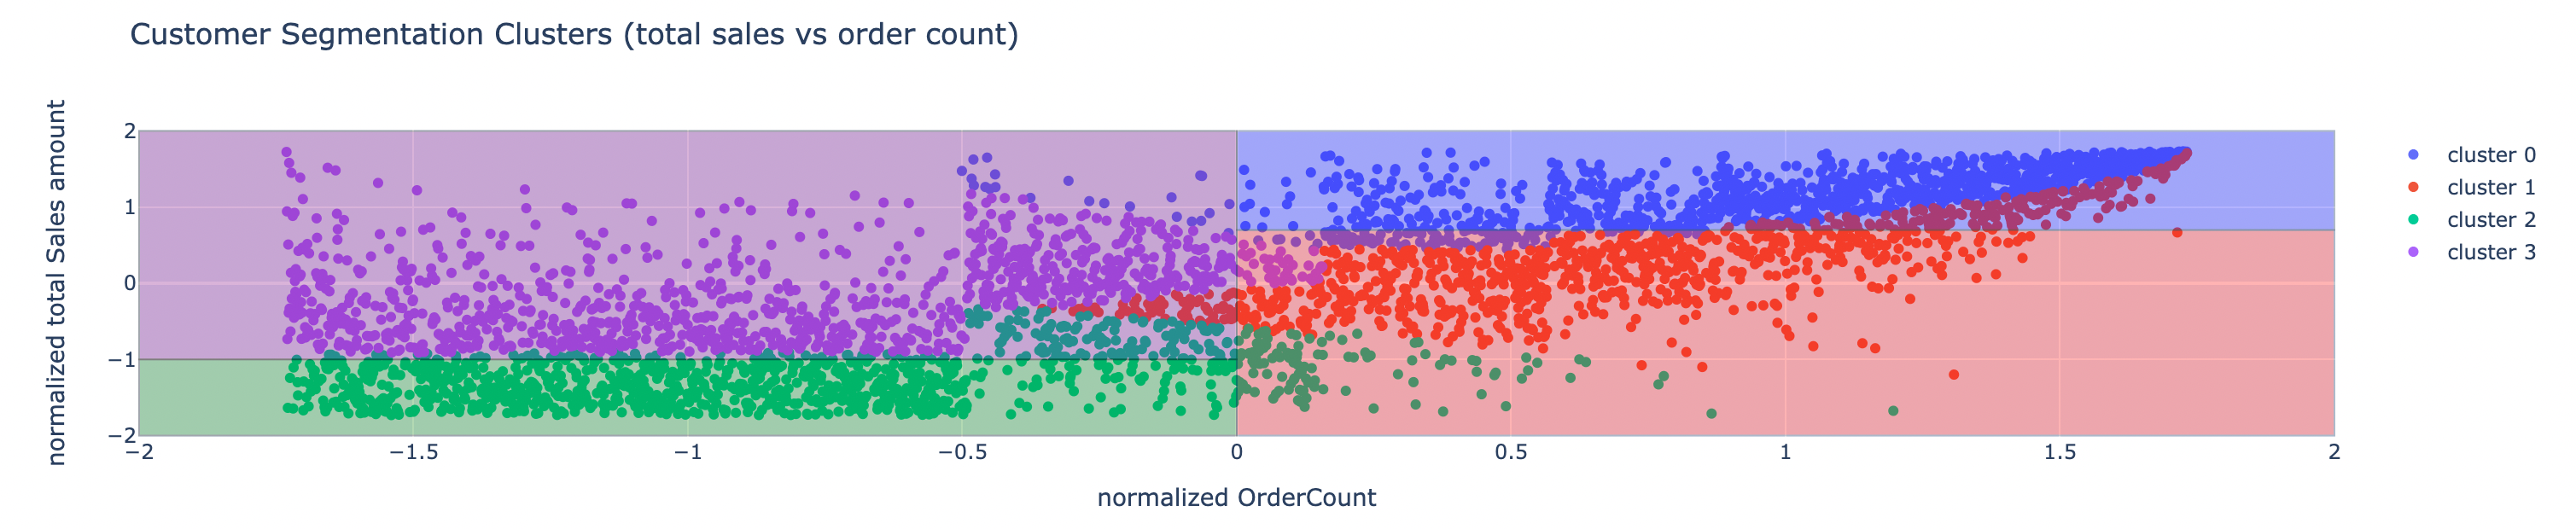

In [57]:
# Filter out cluster data:
cl_1 = four_cluster_df[four_cluster_df['Cluster']==0]
cl_2 = four_cluster_df[four_cluster_df['Cluster']==1]
cl_3 = four_cluster_df[four_cluster_df['Cluster']==2]
cl_4 = four_cluster_df[four_cluster_df['Cluster']==3]

# build scatter fig:
cluster_fig = go.Figure()
cluster_fig.add_trace(go.Scatter(x=cl_1['OrderCount'], y=cl_1['Sales'], mode='markers', name='cluster 0'))
cluster_fig.add_trace(go.Scatter(x=cl_2['OrderCount'], y=cl_2['Sales'], mode='markers', name='cluster 1'))
cluster_fig.add_trace(go.Scatter(x=cl_3['OrderCount'], y=cl_3['Sales'], mode='markers', name='cluster 2'))
cluster_fig.add_trace(go.Scatter(x=cl_4['OrderCount'], y=cl_4['Sales'], mode='markers', name='cluster 3'))

# add regions:
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=-2, y0=-2,
                      x1=0, y1=-1,
                      opacity=0.3,
                      fillcolor='green',
                      line_color="black",
                      line_width=1)
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=-2, y0=-1,
                      x1=0, y1=2,
                      opacity=0.3,
                      fillcolor='purple',
                      line_color="black",
                      line_width=1)
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=0, y0=-2,
                      x1=2, y1=0.7,
                      opacity=0.3,
                      fillcolor='red',
                      # line_color="black",
                      line_width=1)
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=0, y0=0.7,
                      x1=2, y1=2,
                      opacity=0.3,
                      fillcolor='blue',
                      # line_color="black",
                      line_width=1)

# add axis label and title:
cluster_fig.update_layout(title='Customer Segmentation Clusters (total sales vs order count)',
                         xaxis_title='normalized OrderCount',
                         yaxis_title='normalized total Sales amount')
cluster_fig
Image(filename='./images/ch10_1.png', width=1700)

Above we can see we have four distinct regions which we have highlighted by shading each region with the dominant color of their respective constituent nodes.

* GREEN: these represent customers with few orders and small sales amount.
* PURPLE: these are customers with below average order count but that have a wider range of spending habits.
* RED: these customers have above average order counts with approximately average sales amounts.
* BLUE: these are our big spenders, the purchase a lot and spend a lot as well.

&nbsp;

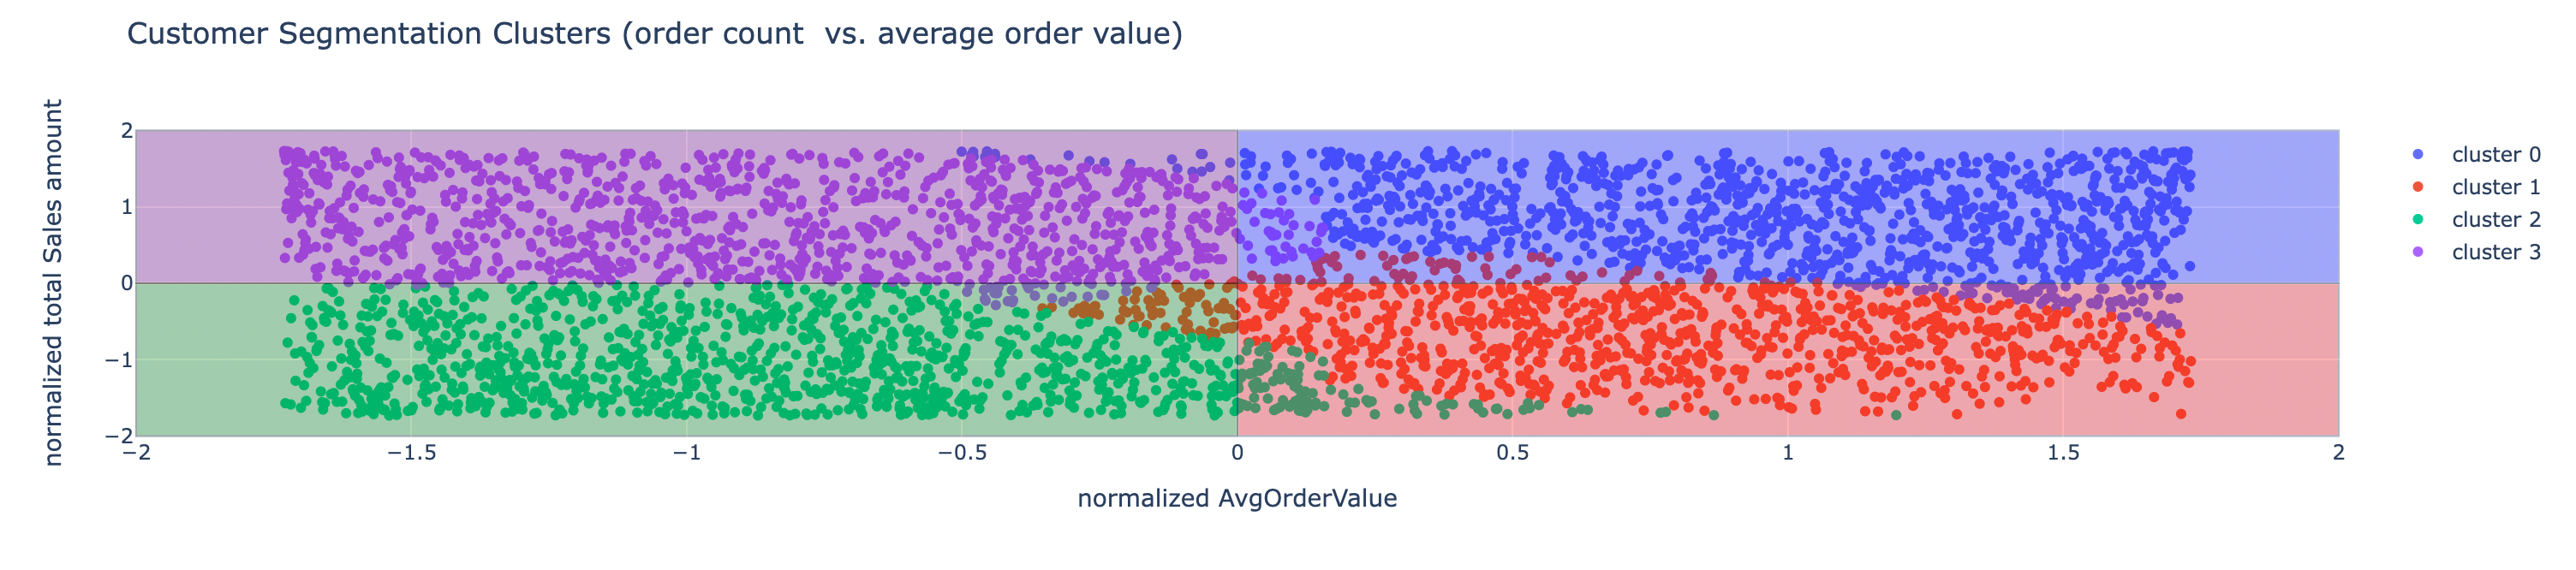

In [56]:
# Filter out cluster data:
cl_1 = four_cluster_df[four_cluster_df['Cluster']==0]
cl_2 = four_cluster_df[four_cluster_df['Cluster']==1]
cl_3 = four_cluster_df[four_cluster_df['Cluster']==2]
cl_4 = four_cluster_df[four_cluster_df['Cluster']==3]

# build scatter fig:
cluster_fig = go.Figure()
cluster_fig.add_trace(go.Scatter(x=cl_1['OrderCount'], y=cl_1['AvgOrderValue'], mode='markers', name='cluster 0'))
cluster_fig.add_trace(go.Scatter(x=cl_2['OrderCount'], y=cl_2['AvgOrderValue'], mode='markers', name='cluster 1'))
cluster_fig.add_trace(go.Scatter(x=cl_3['OrderCount'], y=cl_3['AvgOrderValue'], mode='markers', name='cluster 2'))
cluster_fig.add_trace(go.Scatter(x=cl_4['OrderCount'], y=cl_4['AvgOrderValue'], mode='markers', name='cluster 3'))

# add regions:
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=-2, y0=-2,
                      x1=0, y1=0,
                      opacity=0.3,
                      fillcolor='green',
                      line_color="black",
                      line_width=1)
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=-2, y0=0,
                      x1=0, y1=2,
                      opacity=0.3,
                      fillcolor='purple',
                      line_color="black",
                      line_width=1)
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=0, y0=-2,
                      x1=2, y1=0,
                      opacity=0.3,
                      fillcolor='red',
                      # line_color="black",
                      line_width=1)
cluster_fig.add_shape(type="rect", xref="x", yref="y",
                      x0=0, y0=0,
                      x1=2, y1=2,
                      opacity=0.3,
                      fillcolor='blue',
                      # line_color="black",
                      line_width=1)

# add axis label and title:
cluster_fig.update_layout(title='Customer Segmentation Clusters (order count  vs. average order value)',
                         xaxis_title='normalized AvgOrderValue',
                         yaxis_title='normalized total Sales amount')
cluster_fig
Image(filename='./images/ch10_2.png', width=1700)

&nbsp;

---
### Optimal Number of Clusters
Below we employ the "Silhouette Score" to find the optimal number of clusters.

&nbsp;
#### Search for optimal number of clusters.

In [11]:
for n_cluster in [4,5,6,7,8,9,10]:
    kmeans_ = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['Sales', 'OrderCount', 'AvgOrderValue']])

    silhouette_avg = silhouette_score(
        normalized_df[['Sales', 'OrderCount', 'AvgOrderValue']], 
        kmeans_.labels_)

    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 4 Clusters: 0.4115
Silhouette Score for 5 Clusters: 0.3771
Silhouette Score for 6 Clusters: 0.3784
Silhouette Score for 7 Clusters: 0.3909
Silhouette Score for 8 Clusters: 0.3812
Silhouette Score for 9 Clusters: 0.3764
Silhouette Score for 10 Clusters: 0.3619


**Note:** four clusters provide the best score.

&nbsp;

---
### Interpreting Customer Segments
Below we use the information gathered from each cluster's centroid in order to analyze customer beahvior and identify potential marketing strategies for each segment.

&nbsp;
#### Extract the information from the clusters:
We previously fitted a k-means model, so we'll reuse the information from the resulting object.

In [20]:
# extract the centroids:
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=['Sales_norm', 'OrderCount_norm', 'AvgOrderValue_norm'])
centroids_df.index.name='cluster'
centroids_df

,Sales_norm,OrderCount_norm,AvgOrderValue_norm
cluster,,,
0,1.205252,1.001879,0.871072
1,0.218905,0.715858,-0.642152
2,-1.246752,-0.797124,-1.061982
3,-0.136230,-0.852664,0.796056


&nbsp;

We can interpret the table above as follows:
   * cluster 0: above average (numbers represent standard deviations) values of every attribute. These customers spend a lot and buy a lot. Prime targets for marketing strategies.
    
   * cluster 1: these customers are frequent purchasers of low-value items (low AvgOrderValue) but spend above average due to their shopping frequency. Target these customers with low-value items.
    
   * cluster 2: these customers are our lowest performing segment. They don't buy much and don't spend much either.
    
   * cluster 3: this is an interesting segment. These customers don't purchase a lot of items (low OrderCount and Sales) but their AvgOrderValue is high, meaning that they purchase high-value items. Target them with higher-value goods.

&nbsp;
#### Find best selling items for each cluster:
Group by cluster and return the item with the highest frequency.

In [21]:
# Filter out cluster data:
high_val_cluster = four_cluster_df[four_cluster_df['Cluster']==0]
frequent_spenders_cluster = four_cluster_df[four_cluster_df['Cluster']==1]
low_val_cluster = four_cluster_df[four_cluster_df['Cluster']==2]
high_spenders_cluster = four_cluster_df[four_cluster_df['Cluster']==3]

In [24]:
# find customers in each segment:
high_val_customers = list(high_val_cluster.index)
frequent_spenders_customers = list(frequent_spenders_cluster.index)
low_val_customers = list(low_val_cluster.index)
high_spenders_customers = list(high_spenders_cluster.index)

In [25]:
# define cleaning function:
def tweak_retail_data_2(df):
    tweaked_df = (df
                  .query('Quantity > 0')
                  .assign(InvoiceDate=lambda df_: pd.to_datetime(df_['InvoiceDate']))
                  .query('InvoiceDate < "2011-12-01"')
                  .dropna(subset=['CustomerID'])
                  .assign(Sales=lambda df_: df_['Quantity']*df_['UnitPrice'])
                 )
    return tweaked_df

In [26]:
# return cleaned data:
cleaned_df = tweak_retail_data_2(data)
cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444.0,United Kingdom,5.00
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444.0,United Kingdom,11.90
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444.0,United Kingdom,12.48
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444.0,United Kingdom,7.95


In [52]:
# find most frequently purchased items per cluster:
high_val_df = cleaned_df[cleaned_df['CustomerID'].isin(high_val_customers)]
frequent_spenders_df = cleaned_df[cleaned_df['CustomerID'].isin(frequent_spenders_customers)]
low_val_df = cleaned_df[cleaned_df['CustomerID'].isin(low_val_customers)]
high_spenders_df = cleaned_df[cleaned_df['CustomerID'].isin(high_spenders_customers)]

&nbsp;
##### High Value Customers - Most Frequently Purchased Items:

In [49]:
high_val_df.groupby('Description')[['StockCode']].count().sort_values(by='StockCode', ascending=False).iloc[:5]

,StockCode
Description,
JUMBO BAG RED RETROSPOT,1143
REGENCY CAKESTAND 3 TIER,1080
WHITE HANGING HEART T-LIGHT HOLDER,1072
LUNCH BAG RED RETROSPOT,938
PARTY BUNTING,865


&nbsp;
##### Frequent Spenders - Most Frequently Purchased Items:

In [53]:
frequent_spenders_df.groupby('Description')[['StockCode']].count().sort_values(by='StockCode', ascending=False).iloc[:5]

,StockCode
Description,
WHITE HANGING HEART T-LIGHT HOLDER,613
REX CASH+CARRY JUMBO SHOPPER,437
REGENCY CAKESTAND 3 TIER,318
PARTY BUNTING,309
ASSORTED COLOUR BIRD ORNAMENT,309


&nbsp;
##### Low Value Customers - Most Frequently Purchased Items:

In [54]:
low_val_df.groupby('Description')[['StockCode']].count().sort_values(by='StockCode', ascending=False).iloc[:5]

,StockCode
Description,
REX CASH+CARRY JUMBO SHOPPER,136
WHITE HANGING HEART T-LIGHT HOLDER,133
REGENCY CAKESTAND 3 TIER,79
ASSORTED COLOUR BIRD ORNAMENT,78
BAKING SET 9 PIECE RETROSPOT,72


&nbsp;
##### High Spenders - Most Frequently Purchased Items:

In [55]:
high_spenders_df.groupby('Description')[['StockCode']].count().sort_values(by='StockCode', ascending=False).iloc[:5]

,StockCode
Description,
REGENCY CAKESTAND 3 TIER,199
WHITE HANGING HEART T-LIGHT HOLDER,158
ASSORTED COLOUR BIRD ORNAMENT,155
SET OF 3 CAKE TINS PANTRY DESIGN,151
PARTY BUNTING,137
